In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pystan
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
true_mu1 = 2
true_mu2 = 7
true_sigma1 = 3
true_sigma2 = 1

In [3]:
samples1 = np.random.normal(true_mu1, true_sigma1, 100)
samples2 = np.random.normal(true_mu2, true_sigma2, 100)
samples_all = np.hstack((samples1, samples2))

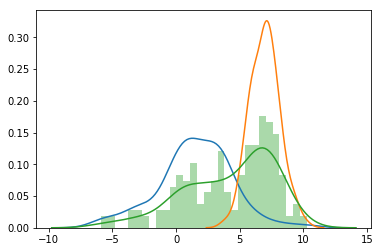

In [4]:
sns.kdeplot(samples1)
sns.kdeplot(samples2)
sns.distplot(samples_all, bins=30)

In [5]:
# get some stats for all data to use later in model as boundaries
np.mean(samples_all), np.min(samples_all), np.max(samples_all), np.std(samples_all)

(4.24135560833661, -5.909896654272848, 10.280984405228248, 3.4990714680910138)

Gaussian Mixture model:

$$
\
p(y \, | \, \theta, \mu, \sigma)
= \prod_{n=1}^N (\theta \times {Normal}(y_n \, | \, \mu_1, \sigma_1)
                 + (1 - \theta) \times {Normal}(y_n \, | \, \mu_2, \sigma_2).
\
$$

In [6]:
model_string = """
data {
  int<lower=1> N;               // number of data points
  real y[N];                    // observations
  real<lower=0,upper=1> theta;  // mixing proportion
}

parameters {
  ordered[2] mu;                // locations of mixture components
  vector<lower=0>[2] sigma;     // scales of mixture components
}

model {
  mu ~ normal(3, 5);
  sigma ~ uniform(0, 5);

  for (n in 1:N) {
     target += log_mix(theta,
                       normal_lpdf(y[n] | mu[1], sigma[1]),
                       normal_lpdf(y[n] | mu[2], sigma[2]));
  }
    
}

generated quantities {
}
"""

In [7]:
data_list = {
    'N': samples_all.shape[0],
    'y': samples_all,
    'theta': 0.5,
}
stan_samples = pystan.stan(model_code=model_string, data=data_list)
stan_samples

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0394fbbc84aee09d9eb3996873b970cd NOW.
/Users/roman/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_0394fbbc84aee09d9eb3996873b970cd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.75  9.3e-3   0.39   0.99   1.48   1.74   2.01   2.55   1779    1.0
mu[1]      6.97  2.7e-3   0.17   6.63   6.87   6.98   7.08   7.29   3762    1.0
sigma[0]   3.05  6.1e-3   0.28   2.53   2.85   3.04   3.23   3.62   2100    1.0
sigma[1]   1.22  2.9e-3   0.15   0.97   1.12   1.21   1.31   1.54   2583    1.0
lp__     -507.2    0.04   1.46 -511.0 -508.0 -506.9 -506.2 -505.4   1069    1.0

Samples were drawn using NUTS at Thu Jun 14 20:14:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

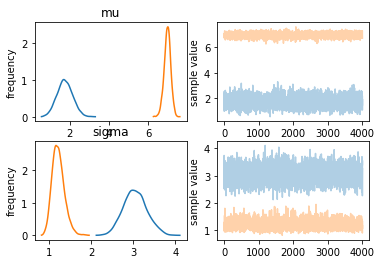

In [8]:
stan_samples.plot();

In [9]:
posterior_samples = stan_samples.extract()

In [10]:
posterior = pd.DataFrame({
    'mu1': posterior_samples['mu'][:,0],
    'mu2': posterior_samples['mu'][:,1],
    'sigma1': posterior_samples['sigma'][:,0],
    'sigma2': posterior_samples['sigma'][:,1],
})
posterior.head()

,mu1,mu2,sigma1,sigma2
0,1.013404,6.779220,2.541711,1.251340
1,2.314326,6.801150,3.742343,1.013640
2,2.061231,6.930593,3.100479,1.254285
3,2.280183,7.025995,3.075088,0.970887
4,1.547966,7.105406,3.144782,1.296761


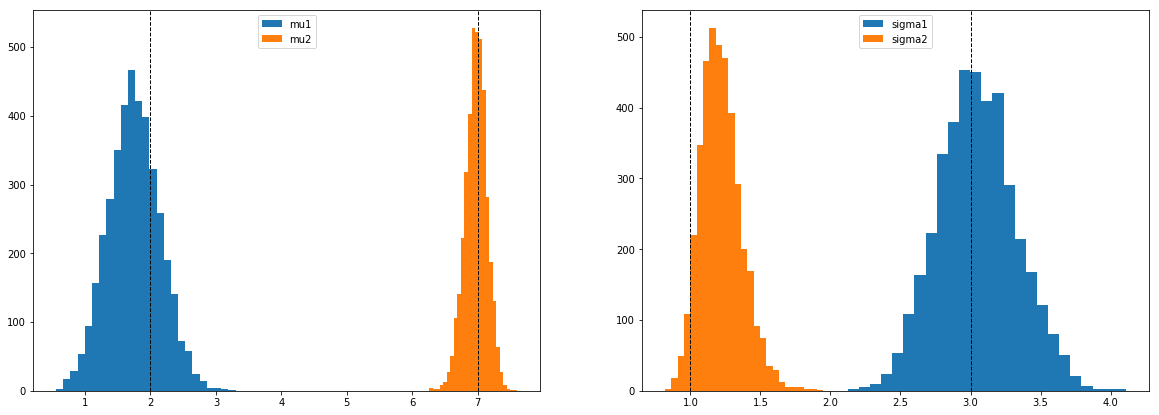

In [11]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,7))
ax0.hist(posterior['mu1'][:], 25, label="mu1")
ax0.axvline(true_mu1, color='k', linestyle='dashed', linewidth=1)
ax0.hist(posterior['mu2'][:], 25, label="mu2")
ax0.axvline(true_mu2, color='k', linestyle='dashed', linewidth=1)
ax0.legend(loc="upper center")
ax1.hist(posterior['sigma1'][:], 25, label="sigma1")
ax1.axvline(true_sigma1, color='k', linestyle='dashed', linewidth=1)
ax1.hist(posterior['sigma2'][:], 25, label="sigma2")
ax1.axvline(true_sigma2, color='k', linestyle='dashed', linewidth=1)
ax1.legend(loc="upper center");

In [12]:
posterior.mu1.median(), posterior.mu2.median(), posterior.sigma1.median(), posterior.sigma2.median()

(1.7408646496749154, 6.979604584359456, 3.039211918551824, 1.2076153224391708)

# Let's find MAP (maximum a posteriori probability)

In [15]:
sm = pystan.StanModel(model_code=model_string)
op = sm.optimizing(data=data_list)
op

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0394fbbc84aee09d9eb3996873b970cd NOW.
/Users/roman/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


OrderedDict([('mu', array([1.73473664, 7.01437511])),
             ('sigma', array([2.96674259, 1.17314198]))])

In [16]:
# And you can always just fit_predict
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2)
gm.fit(samples_all.reshape((-1, 1)))
print(gm.means_.flatten())
print(gm.covariances_.flatten()**0.5)

[7.01774843 1.74305983]
[1.17955744 2.97168511]


To learn Bayesian I'd recommend start from 3 short videos "Introduction to Bayesian data analysis"
https://www.youtube.com/watch?v=3OJEae7Qb_o
and move to the book "Statistical Rethinking" https://xcelab.net/rm/statistical-rethinking/